In [ ]:
# Setup path to import src
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils.cds_plotter import CDSPlotter

In [ ]:
from src.utils import config
# Example usage with new paths:
# plotter = CDSPlotter()
# plotter.load_data('GARCH', config.OUTPUT_DIR / 'cds_spreads_garch_mc.csv')

# CDS Spread Visualization

This notebook demonstrates how to use the `CDSPlotter` class to visualize CDS spreads from different models.

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of cds_spread_calculator failed: Traceback (most recent call last):
  File "c:\Users\Chase\Downloads\Seminar QF\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "c:\Users\Chase\Downloads\Seminar QF\.venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 546, in maybe_reload_module
    new_source_code = f.read()
  File "C:\Users\Chase\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 20469: character maps to <undefined>
]


In [ ]:
import importlib
from src.utils import cds_plotter

# Force reload to pick up changes
importlib.reload(cds_plotter)
from src.utils.cds_plotter import CDSPlotter

In [ ]:
# Initialize the plotter
plotter = CDSPlotter()

# Load the data using config paths
from src.utils import config

# Check if files exist before loading
garch_file = config.OUTPUT_DIR / 'cds_spreads_garch_mc.csv'
rs_file = config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc.csv'

if garch_file.exists():
    plotter.load_data('GARCH', garch_file)
else:
    print(f"Warning: {garch_file} not found.")

if rs_file.exists():
    plotter.load_data('Regime Switching', rs_file)
else:
    print(f"Warning: {rs_file} not found.")

Loading data for GARCH from cds_spreads_garch_mc.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 30349 rows for GARCH.
Loading data for Regime Switching from cds_spreads_regime_switching_mc.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 30349 rows for Regime Switching.


## 1. GARCH Model Results
Visualizing the term structure of CDS spreads over time for the GARCH model.

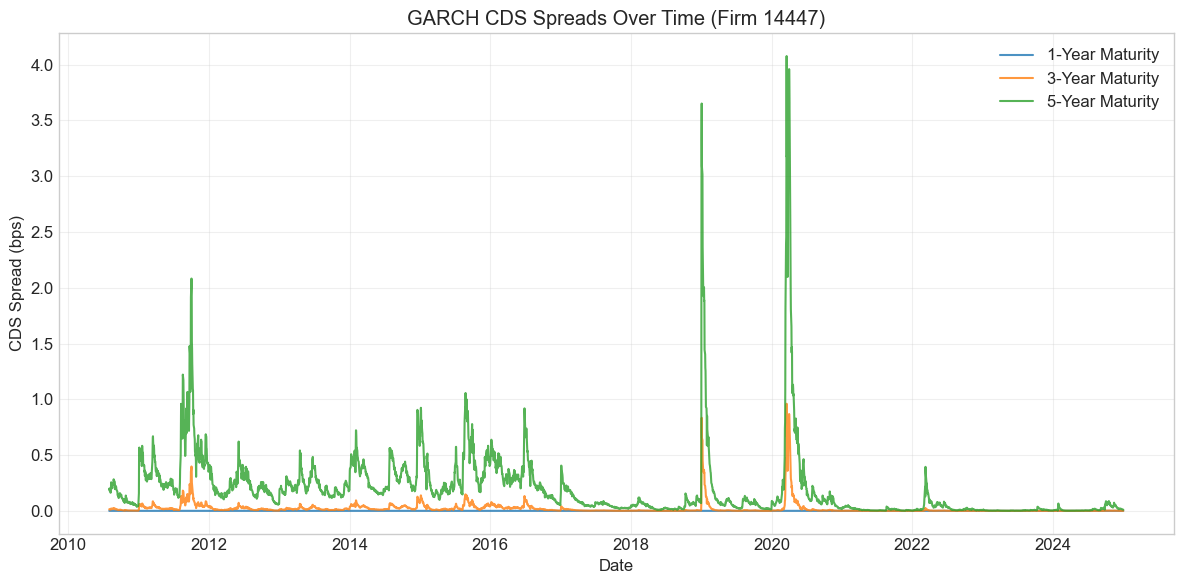

In [46]:
# Plot for firm 14447 
plotter.plot_spreads_over_time('GARCH', gvkey=14447, maturities=[1, 3, 5])

## 2. Regime Switching Model Results
Visualizing the term structure of CDS spreads over time for the Regime Switching model.

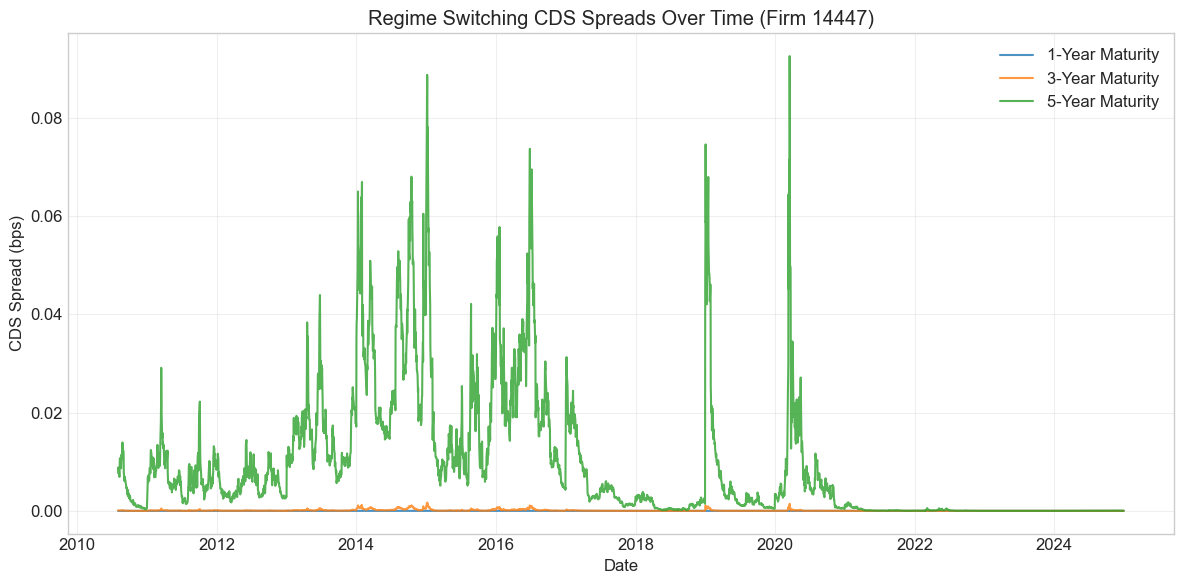

In [50]:
plotter.plot_spreads_over_time('Regime Switching', gvkey=14447, maturities=[1, 3, 5])

## 3. Model Comparison
Comparing the 5-year CDS spread estimates between models.

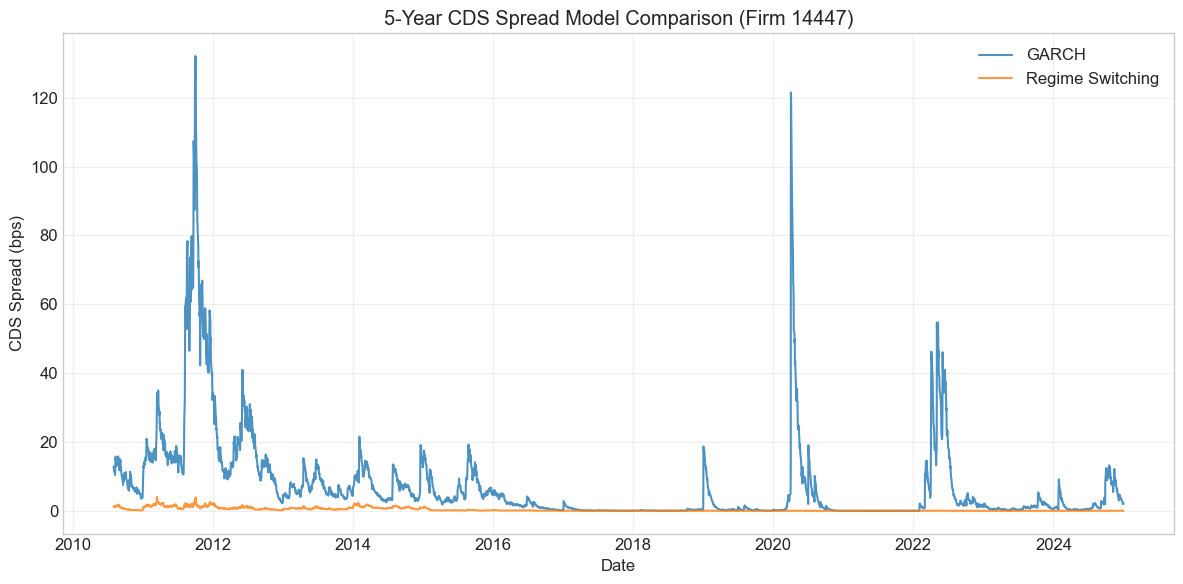

In [6]:
plotter.plot_model_comparison(gvkey=14447, maturity=5, models=['GARCH', 'Regime Switching'])

## 4. Average Spreads Across All Firms
Visualizing the average CDS spreads for all firms in the dataset (GARCH model).

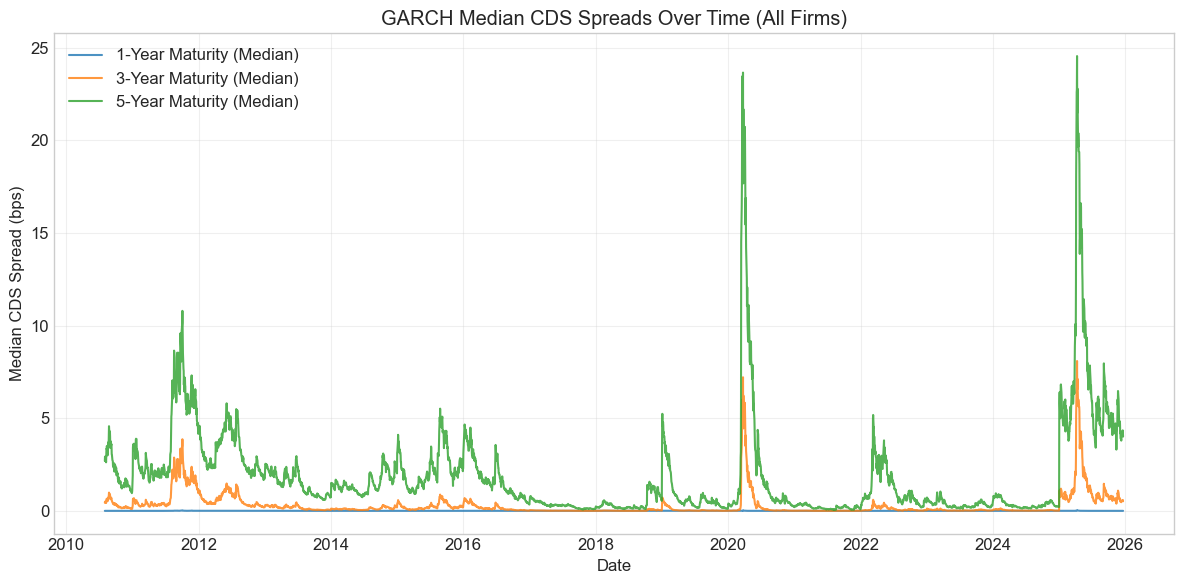

In [51]:
plotter.plot_average_spreads_over_time('GARCH', maturities=[1, 3, 5])